# Анализ временного ряда цены урана

<AxesSubplot: xlabel='DMY'>

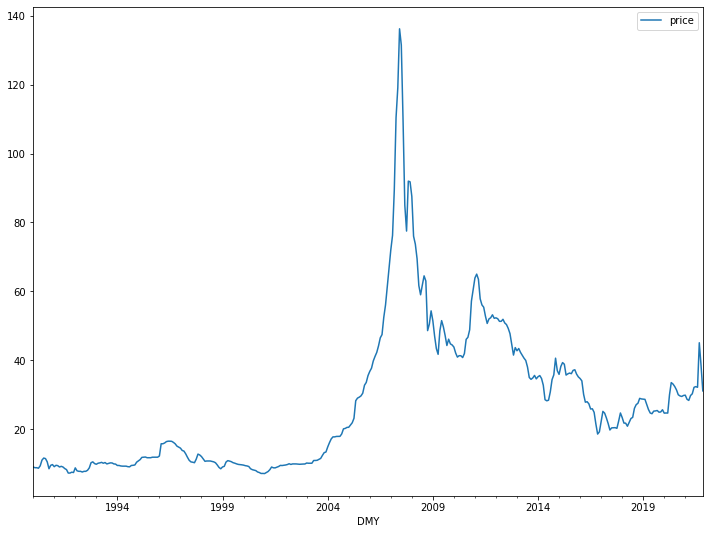

In [10]:
from pandas import read_excel, DataFrame
import statsmodels.api as sm
import numpy as np
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
from tqdm import tqdm
import warnings
import pandas as pd
from itertools import product
#Считаем данные из таблицы
data=read_excel('Uranium_07_07_22-07_14_20.xlsx',index_col=[0],parse_dates=[0])
data.plot(figsize=(12,9))


<AxesSubplot: xlabel='DMY'>

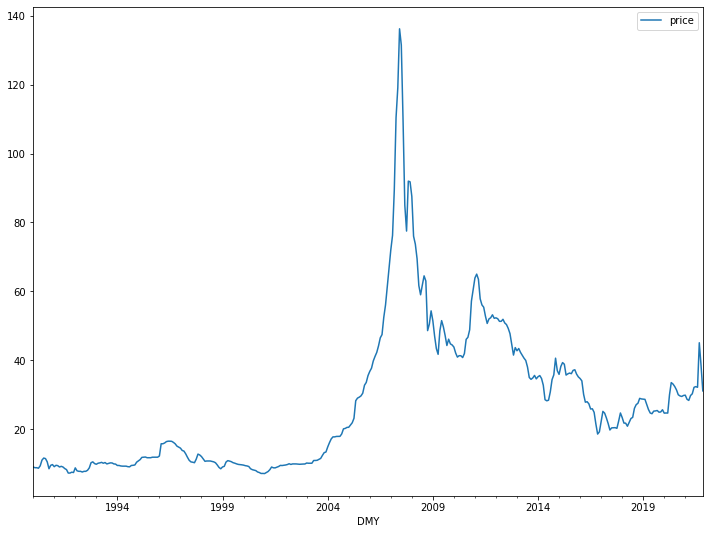

In [11]:
#Сглаживаем данные по месяцам
data = data.resample('M').mean()
data.plot(figsize=(12,9))

In [12]:
#Тест Харки-Бера
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

          JB          
----------------------
     522.6503708753082
3.220430878062646e-114
     1.775177654259509
    7.4884200184050425
----------------------


In [13]:
#Проведем обобщенный тест Дикки-Фуллера 
test_adfuller = sm.tsa.adfuller(data)
print('adf: ', test_adfuller[0])
print('p-value: ', test_adfuller[1])
print('Critical values: ', test_adfuller[4])
if test_adfuller[0]> test_adfuller[4]['5%']: 
    print('Ряд не стационарен')
else:
    print('Ряд стационарен')

adf:  -2.3123340862015764
p-value:  0.1680208354810928
Critical values:  {'1%': -3.447909006729481, '5%': -2.8692783343881483, '10%': -2.5708923751111112}
Ряд не стационарен


<AxesSubplot: xlabel='DMY'>

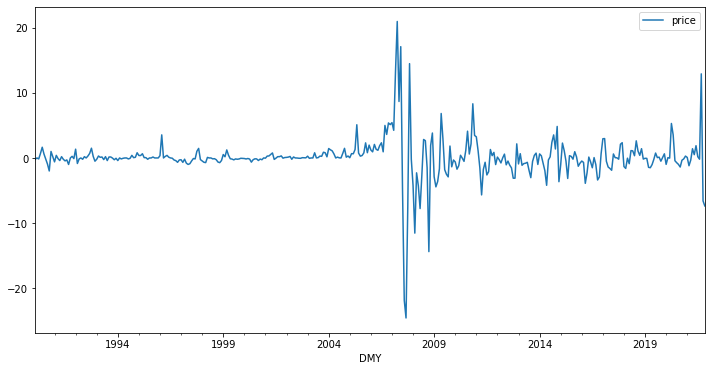

In [14]:
dataf = data.diff(periods=1).dropna()
dataf.plot(figsize=(12,6))
#Построение ряда первых разностей, он стационарен

In [18]:
src_data_model = data[:'2018-11-01']
warnings.filterwarnings('ignore')
#Произведем обучение модели ARIMA на 80% данных
#Для выбора параметров произведем перебор
#Критерием оптимальности будет критерий Акаике 
ps = range(0, 5)
d=1
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)
results = []
best_aic = float("inf")
for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(src_data_model, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('Ошибка:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.78it/s]

   parameters          aic
9      (1, 4)  1663.330029
14     (2, 4)  1665.327732
23     (4, 3)  1666.072656
18     (3, 3)  1666.208894
4      (0, 4)  1666.959769


In [19]:
#Произведем Q-тест Льюинга-Бокса для доказательства, что остатки случайны
q_test = sm.tsa.stattools.acf(model.resid, qstat=True)
print(DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.000140  0.990566
1    0.002232  0.998884
2    0.042859  0.997670
3    0.046260  0.999737
4    1.644374  0.895832
5    1.715303  0.943934
6    1.931796  0.963519
7    2.216371  0.973649
8    4.118246  0.903459
9    6.441288  0.776927
10   8.708102  0.648816
11   9.649560  0.646674
12  10.335819  0.666270
13  11.465933  0.649108
14  13.834095  0.538147
15  15.500348  0.488342
16  16.980271  0.455704
17  16.987534  0.523962
18  17.042214  0.587008
19  17.287306  0.634247
20  17.922264  0.653918
21  25.993218  0.251973
22  29.808240  0.154986
23  29.968755  0.185790
24  30.423303  0.208830


In [20]:
# Предскажем данные до 2035 
pred218 = best_model.get_forecast(200)
pred=pred218.predicted_mean
yhat_conf_int = pred218.conf_int(alpha=0.05)
nf=pd.concat([pred, yhat_conf_int])
print(pred)

2018-11-30    26.954445
2018-12-31    26.507984
2019-01-31    26.780217
2019-02-28    26.694718
2019-03-31    26.739777
                ...    
2035-02-28    26.724226
2035-03-31    26.724226
2035-04-30    26.724226
2035-05-31    26.724226
2035-06-30    26.724226
Freq: M, Name: predicted_mean, Length: 200, dtype: float64
